<a href="https://colab.research.google.com/github/pen1064/OhCrack/blob/main/RoadCrack_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
! pip install barbar

In [3]:
import os 
import numpy as np
import glob
from barbar import Bar
from xml.etree import ElementTree as ET
import pandas as pd
import plotly.express as px
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision
from torchvision import transforms, datasets, models
import time
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
iamge_directory = '/content/gdrive/MyDrive/Crack/Japan/images/'
JDATA = {'filename':[], 'dim':[], 'type':[], 'bndbx':[]}


for file in glob.glob('/content/gdrive/MyDrive/Crack/Japan/annotations/xmls/*.xml'):
  tree = ET.parse(file)
  root = tree.getroot() 
  filename = root.find('filename').text
  dim =[int(a.text) for a in root.find('size')]
  for i in root.findall('object'):
      JDATA['filename'] += [iamge_directory+filename]
      JDATA['dim'] += [dim]
      JDATA['type'] += [i.find('name').text]
      JDATA['bndbx'] += [[int(a.text) for a in i.find('bndbox')]]


In [ ]:
#train_df = pd.DataFrame.from_dict(JDATA) 
#train_df.head(3)
#train_df.to_csv('/content/gdrive/MyDrive/Crack/Japan/train_df.csv', index=False)
df = pd.read_csv('/content/gdrive/MyDrive/Crack/Japan/trainall.csv')
df['bndbx'] = df['bndbx'].apply(lambda z: eval(z))
df['dim'] = df['dim'].apply(lambda z: eval(z))
df.dtypes
df.head(3)

,filename,dim,type,bndbx
0,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",D40,"[277, 521, 324, 535]"
1,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",D40,"[22, 437, 48, 470]"
2,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",D50,"[257, 536, 360, 583]"


In [ ]:
fig = px.pie(df, "type")
fig.update_layout(height=400, width = 400)
fig.show()

In [ ]:
df['type'] = pd.Categorical(df['type'])
crack_type = dict( enumerate(df['type'].cat.categories ) )
df['type'] = df['type'].cat.codes
df.head(3)

,filename,dim,type,bndbx
0,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",3,"[277, 521, 324, 535]"
1,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",3,"[22, 437, 48, 470]"
2,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",6,"[257, 536, 360, 583]"


In [ ]:
print(crack_type)

{0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40', 4: 'D43', 5: 'D44', 6: 'D50'}


In [ ]:
Bad_Data = []
for i in range(len(df)):
  z = list(df.loc[i, 'bndbx'])
  if z[0] >= z[2] or z[1] >= z[3]:
    Bad_Data.append(i)
print(Bad_Data)

[24650]


In [ ]:
[df.drop(index = i, axis = 0, inplace=True) for i in Bad_Data]
df.reset_index(inplace=True)

In [ ]:
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv',)

In [ ]:
#{0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40', 4: 'D43', 5: 'D44', 6: 'D50'}


In [5]:
train_df = pd.read_csv('/content/gdrive/MyDrive/Crack/Japan/train_df_2.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/Crack/Japan/test_df_2.csv')

train_df['type'] = train_df['type'].astype(int)
test_df['type'] = test_df['type'].astype(int)

train_df['bndbx'] = train_df['bndbx'].apply(lambda z: eval(z))
test_df['bndbx'] = test_df['bndbx'].apply(lambda z: eval(z))

train_df['dim'] = train_df['dim'].apply(lambda z: eval(z))
test_df['dim'] = test_df['dim'].apply(lambda z: eval(z))


Need to transform the bndbx

In [6]:
class MaskDataset(object):
    def __init__(self, df):
        self.transforms = transforms
        self.df = df
        self.imgs =df['filename'].unique()

    def __getitem__(self, idx): 
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        tc = transforms.Compose([transforms.ToTensor()])
        img = tc(img)

        target={}
        target['boxes'] = torch.as_tensor(self.df[self.df['filename'] == self.imgs[idx]]['bndbx'].to_list(), dtype=torch.float32)
        target['labels'] = torch.as_tensor(self.df[self.df['filename'] == self.imgs[idx]]['type'].to_list(), dtype=torch.int64)
 
        return img, target

    def __len__(self): 
        return len(self.imgs)


def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
dataset = MaskDataset(train_df)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
test_dataset = MaskDataset(test_df)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
def get_model_instance_segmentation(num_classes, **kwargs):
    model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=num_classes, pretrained=False, pretrained_backbone=True, trainable_backbone_layers=5)#take backbone
    if 'weights' in kwargs:
      if torch.cuda.is_available():
        model.load_state_dict(torch.load(kwargs['weights']))
      else:
        model.load_state_dict(torch.load(kwargs['weights'], map_location=torch.device('cpu')))
    return model

In [8]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.resnet import resnet50
from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.models.detection.retinanet import RetinaNet
        
def get_model_instance_finetning(num_classes, **kwargs):
    backbone = resnet50(pretrained=True)

    backbone = _resnet_fpn_extractor(backbone, trainable_layers=5, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(256, 256))
    anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512])
    aspect_ratios = ((0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    print(anchor_sizes)
    print(aspect_ratios)
   

    model = RetinaNet(backbone, num_classes=7,anchor_generator=anchor_generator )

    if 'weights' in kwargs:
      if torch.cuda.is_available():
        model.load_state_dict(torch.load(kwargs['weights']))
      else:
        model.load_state_dict(torch.load(kwargs['weights'], map_location=torch.device('cpu')))
    return model

#model1 = get_model_instance_finetning(7, anchors_input)

In [22]:
#model = get_model_instance_segmentation(7) #no need background classes because it is using sigmoid not softmax
model = get_model_instance_finetning(7, weights ='/content/gdrive/MyDrive/Crack/fine_tuning_more_smaller_anchors_retina_84.pt') 
#model = get_model_instance_finetning(7, anchors_input)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

((32, 40, 50), (64, 80, 101), (128, 161, 203), (256, 322, 406), (512, 645, 812))
((0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6), (0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6), (0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6), (0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6), (0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6))


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [ ]:
num_epochs = 30
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001,momentum=0.9, weight_decay=0.0005) #change from 0.001
losses_epoch = []
for epoch in range(num_epochs):
    start = time.time()
    print(start)
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in Bar(data_loader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
        
    print(f'epoch : {epoch+82}, Loss : {epoch_loss}, time : {time.time() - start}')
    losses_epoch.append(epoch_loss)
    print(losses_epoch)
    
    torch.save(model.state_dict(),'/content/gdrive/MyDrive/Crack/fine_tuning_more_smaller_anchors_retina_{}.pt'.format(epoch+82))

1652304272.1634738
5337/5337: [===============================>] - ETA 3.2s
epoch : 82, Loss : 70.06685638427734, time : 3356.3269667625427
[tensor(70.0669, device='cuda:0', grad_fn=<AddBackward0>)]
1652307631.2499843
5337/5337: [===============================>] - ETA 0.5s
epoch : 83, Loss : 57.72374725341797, time : 645.6185653209686
[tensor(70.0669, device='cuda:0', grad_fn=<AddBackward0>), tensor(57.7237, device='cuda:0', grad_fn=<AddBackward0>)]
1652308280.1578467
5337/5337: [===============================>] - ETA 0.5s
epoch : 84, Loss : 50.44890594482422, time : 646.156779050827
[tensor(70.0669, device='cuda:0', grad_fn=<AddBackward0>), tensor(57.7237, device='cuda:0', grad_fn=<AddBackward0>), tensor(50.4489, device='cuda:0', grad_fn=<AddBackward0>)]
1652308926.879271
5337/5337: [===============================>] - ETA 0.5s
epoch : 85, Loss : 45.919307708740234, time : 644.848813533783
[tensor(70.0669, device='cuda:0', grad_fn=<AddBackward0>), tensor(57.7237, device='cuda:0', gr

# Fine Tuning Details
fine_tuning_more_anchor_retina_73    
anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512])\
aspect_ratios = ((0.5, 1.0, 2.0, 4.0, 6),) * len(anchor_sizes)

fine_tuning_more_small_anchors_retina
anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512])\
aspect_ratios = ((0.1, 0.2, 0.5, 1.0, 2.0, 4, 6),) * len(anchor_sizes)

In [9]:
#model = get_model_instance_segmentation(7, weights='fretina_44.pt') #no need background classes because it is using sigmoid not softmax
model = get_model_instance_finetning(7, weights='/content/gdrive/MyDrive/Crack/fine_tuning_more_smaller_anchors_retina_103.pt') #no need background classes because it is using sigmoid not softmax

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

((32, 40, 50), (64, 80, 101), (128, 161, 203), (256, 322, 406), (512, 645, 812))
((0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6), (0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6), (0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6), (0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6), (0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6))


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [10]:
test_dataset = MaskDataset(test_df)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [11]:
def model_predict(model, img, threshold):
  model.eval()
  preds = model(img)
  #print(preds)
  #print(preds[0])
  for ind_p in range(len(preds)):
    idxx = []
    for idx_s, score in enumerate(preds[ind_p]['scores']):
      if score > threshold:
        idxx.append(idx_s)

    preds[ind_p]['boxes'] = preds[ind_p]['boxes'][idxx]
    preds[ind_p]['scores'] = preds[ind_p]['scores'][idxx]
    preds[ind_p]['labels'] = preds[ind_p]['labels'][idxx]
  return preds

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = model_predict(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device(device)) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 1094/1094 [04:24<00:00,  4.13it/s]


In [15]:
def calculate_IoU(box1, box2):
  #print(box1)
  #print(box2)
  intersect_w = torch.min(box1[2], box2[2]) - torch.max(box1[0], box2[0])
  intersect_h = torch.min(box1[3], box2[3]) - torch.max(box1[1], box2[1])
  intersect_area = intersect_w*intersect_h
  union_area = (box1[2] - box1[0])*(box1[3] - box1[1]) + (box2[2] - box2[0])*(box2[3] - box2[1]) - intersect_area
  return intersect_area/union_area

# Precision = true_positive/predicted_positive
def evaluate_scores(p, a, num_classes, iou_threshold):
  scores = []
  for c in range(num_classes):
    num_i = 0
    gt = a['boxes'][torch.isin(a['labels'], c)]
    p_bx, p_scores = p['boxes'][torch.isin(p['labels'],c)], p['scores'][torch.isin(p['labels'],c)]
    
    if len(gt) == 0 or len(p_bx) == 0:
      scores.append(0)
    elif len(gt) == 0 and len(p_bx) != 0:
      scores.append(0)
      num_i += 1
    else:
      s = 0
      for pbx_ind, pbx in enumerate(p_bx):
        for gtt in gt:
          iou = calculate_IoU(pbx, gtt)
          print('iou', iou)
          if iou > iou_threshold:
            s+= float(p_scores[pbx_ind])
      #print(s)
      scores.append(s/len(p_scores))
  return scores


iou_threshold = 0.5

# Calculate average precision 
precisions = []
for batch_num, p_batch in enumerate(preds_adj_all):#preds_adj_all:
  # in each batch
  for pi, p in enumerate(p_batch):
    # in each pic
    scores = evaluate_scores(p, annot_all[batch_num][pi], 7, iou_threshold)
    #print(scores)
    precisions.append(scores)
    
pms = np.array(precisions)
print({0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40', 4: 'D43', 5: 'D44', 6: 'D50'})
print([np.sum(pms[:,i])/len(np.nonzero(pms[:,i])[0])  for i in range(7)])

Streaming output truncated to the last 5000 lines.
iou tensor(-0.0260, device='cuda:0')
iou tensor(0.7229, device='cuda:0')
iou tensor(0.0630, device='cuda:0')
iou tensor(0.0396, device='cuda:0')
iou tensor(0.3519, device='cuda:0')
iou tensor(0.7650, device='cuda:0')
iou tensor(1.6407, device='cuda:0')
iou tensor(0.4282, device='cuda:0')
iou tensor(0.5740, device='cuda:0')
iou tensor(0.9005, device='cuda:0')
iou tensor(-0.5482, device='cuda:0')
iou tensor(0.7445, device='cuda:0')
iou tensor(0.1956, device='cuda:0')
iou tensor(0.6601, device='cuda:0')
iou tensor(-0.0006, device='cuda:0')
iou tensor(0.7554, device='cuda:0')
iou tensor(0.7418, device='cuda:0')
iou tensor(0.7646, device='cuda:0')
iou tensor(0.8584, device='cuda:0')
iou tensor(0.4433, device='cuda:0')
iou tensor(0.0056, device='cuda:0')
iou tensor(0.4965, device='cuda:0')
iou tensor(0.0908, device='cuda:0')
iou tensor(0.1124, device='cuda:0')
iou tensor(0.0496, device='cuda:0')
iou tensor(0.6062, device='cuda:0')
iou tensor

In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

torch.Size([1, 3, 600, 600])
[{'boxes': tensor([[562.0457, 512.1334, 600.0000, 560.5203]], device='cuda:0'), 'scores': tensor([1.0000], device='cuda:0'), 'labels': tensor([6], device='cuda:0')}]
1
<class 'list'>


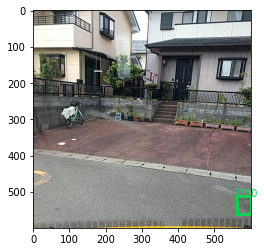

In [13]:
FILES = [r'/content/gdrive/MyDrive/Crack/Japan/images/Japan_012818.jpg']
for file in FILES:
  img1 = Image.open(file).convert("RGB") 
  tc = transforms.Compose([transforms.Resize((600,600)), transforms.ToTensor()])
  img = tc(img1)
  img = img.unsqueeze(0)
  print(img.shape)

  img = img.to(device)
  with torch.no_grad():
    p = model_predict(model, img, 0.5)
    
  print(p)
  print(len(p))

  fig, ax = plt.subplots()
  ax.imshow(img1)

  colors = ['#C7980A', '#F4651F', '#82D8A7', '#CC3A05', '#575E76', '#156943', '#0BD055', '#ACD338']
  category = {0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40', 4: 'D43', 5: 'D44', 6: 'D50'}
  for i, pp in enumerate(p):
   #print(pp)

    for ii, bb in enumerate(pp['boxes']):
      b = bb.cpu().numpy()
      if type(pp['labels']) is not list:
        pp['labels'] = list(pp['labels'])
        print(type(pp['labels']))
      if pp['labels'][ii] == 0:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[0], facecolor='none')
        ax.annotate(category[0], (b[0], b[1]), color=colors[0])
      elif pp['labels'][ii] == 1:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[1], facecolor='none')
        ax.annotate(category[1], (b[0], b[1]), color=colors[1])
      elif pp['labels'][ii] == 2:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[2], facecolor='none')
        ax.annotate(category[2], (b[0], b[1]), color=colors[2])
      elif pp['labels'][ii] == 3:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[3], facecolor='none')
        ax.annotate(category[3], (b[0], b[1]), color=colors[3])
      elif pp['labels'][ii] == 4:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[4], facecolor='none')
        ax.annotate(category[4], (b[0], b[1]), color=colors[4])
      elif pp['labels'][ii] == 5:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[5], facecolor='none')
        ax.annotate(category[5], (b[0], b[1]), color=colors[5])
      else:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[6], facecolor='none')
        ax.annotate(category[6], (b[0], b[1]), color=colors[6])
      ax.add_patch(rect) 
    plt.show()


In [ ]:
def bdx_ratio(z):
  w = z[2] - z[0]
  h = z[3] - z[1]
  return w/h
ratio = train_df[train_df['type'] == 0]['bndbx'].apply(lambda z: bdx_ratio(z))
print('0', ratio.mean())

ratio = train_df[train_df['type'] == 1]['bndbx'].apply(lambda z: bdx_ratio(z))
print('1', ratio.mean())

ratio = train_df[train_df['type'] == 2]['bndbx'].apply(lambda z: bdx_ratio(z))
print('2', ratio.mean())

ratio = train_df[train_df['type'] == 3]['bndbx'].apply(lambda z: bdx_ratio(z))
print('3', ratio.mean())

ratio = train_df[train_df['type'] == 4]['bndbx'].apply(lambda z: bdx_ratio(z))
print('4', ratio.mean())

ratio = train_df[train_df['type'] == 5]['bndbx'].apply(lambda z: bdx_ratio(z))
print('5', ratio.mean())

ratio = train_df[train_df['type'] == 6]['bndbx'].apply(lambda z: bdx_ratio(z))
print('6', ratio.mean())

[0.7205600053300485, 0.5860989668862128, 0.7340354151288516, 0.7083525246281152, 0.8401055514062725, 0.7942786795131376, 0.9048186977082462]

0 0.8498459282263794
1 5.535879661688954
2 1.5921278299868569
3 1.724601425707079
4 4.281727402996237
5 1.3972488277368889
6 3.220157639706623


[0.7205600053300485,
 0.5860989668862128,
 0.7340354151288516,
 0.7083525246281152,
 0.8401055514062725,
 0.7942786795131376,
 0.9048186977082462]

In [ ]:
def bdx_ratio(z):
  w = z[2] - z[0]
  h = z[3] - z[1]
  return w
ratio = train_df[train_df['type'] == 0]['bndbx'].apply(lambda z: bdx_ratio(z))
print('0', ratio.mean())

ratio = train_df[train_df['type'] == 1]['bndbx'].apply(lambda z: bdx_ratio(z))
print('1', ratio.mean())

ratio = train_df[train_df['type'] == 2]['bndbx'].apply(lambda z: bdx_ratio(z))
print('2', ratio.mean())

ratio = train_df[train_df['type'] == 3]['bndbx'].apply(lambda z: bdx_ratio(z))
print('3', ratio.mean())

ratio = train_df[train_df['type'] == 4]['bndbx'].apply(lambda z: bdx_ratio(z))
print('4', ratio.mean())

ratio = train_df[train_df['type'] == 5]['bndbx'].apply(lambda z: bdx_ratio(z))
print('5', ratio.mean())

ratio = train_df[train_df['type'] == 6]['bndbx'].apply(lambda z: bdx_ratio(z))
print('6', ratio.mean())

[0.7205600053300485, 0.5860989668862128, 0.7340354151288516, 0.7083525246281152, 0.8401055514062725, 0.7942786795131376, 0.9048186977082462]

0 71.29684601113172
1 151.58156348847717
2 234.89628349178912
3 70.24143556280588
4 418.7464114832536
5 177.66363636363636
6 63.92766174223128


[0.7205600053300485,
 0.5860989668862128,
 0.7340354151288516,
 0.7083525246281152,
 0.8401055514062725,
 0.7942786795131376,
 0.9048186977082462]

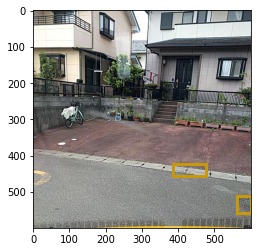

In [14]:
# show the original annotation
fn = '/content/gdrive/MyDrive/Crack/Japan/images/Japan_012818.jpg'
img = Image.open(fn).convert("RGB")
bdxs = [[562, 512, 600, 560], [385, 424, 478, 457]]
fig, ax = plt.subplots()
ax.imshow(img)
for b in bdxs:
   rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[0], facecolor='none')
   ax.add_patch(rect) 
plt.show()


256
RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
import torch
import torchvision
from torchvision.models.detection import KeypointRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                            aspect_ratios=((0.5, 1.0, 2.0),))


backbone = torchvision.models.mobilenet_v2(pretrained=True).features

backbone.out_channels = 1280

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                 output_size=7,
                                                sampling_ratio=2)

keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                         output_size=14,
                                                         sampling_ratio=2)
# put the pieces together inside a KeypointRCNN model
model = KeypointRCNN(backbone,num_classes=2,
rpn_anchor_generator=anchor_generator,
box_roi_pool=roi_pooler,
keypoint_roi_pool=keypoint_roi_pooler)
model.eval()
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]